In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn 
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import time
import scipy
from PIL import Image
from scipy import ndimage
from google.colab import files
import collections

seed = 1
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

%matplotlib inline

In [2]:
transformCustom = transforms.Compose([
                                transforms.ToTensor(), #this convert to tensor
                                transforms.Lambda(lambda x:x.view(-1)),  #this flatten 28*28 into a 784 vector for each image
])

dataset = datasets.KMNIST(root='.',train=True,transform=transformCustom, download=True)
test = datasets.KMNIST(root='.', train=False, transform=transformCustom,download=True)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw



In [3]:
#Split the dataset into train and validation set
n_train = 50000
n_valid= 10000
train_data, valid_data = data.random_split(dataset, [n_train, n_valid])

##Check 1. Visualize a few sample images from the dataset

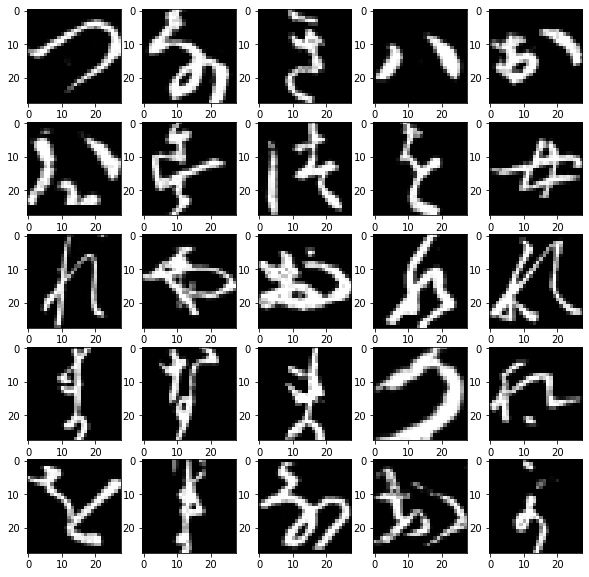

In [4]:
plt.figure(figsize=(10,10))
for i in range(25): #visualizing first 25 images from the training set
    plt.subplot(5,5,i+1) 
    image, label = train_data[i]
    plt.imshow(image.reshape((28,28)), cmap='gray')
plt.show()

##Check 2. Check the number of instances of each labels in both training and test dataset.


In [5]:
def print_instance(dataset):
  print("--Number of instances for each classes--")
  label = []
  for i in range(len(dataset)):
    label.append(dataset[i][1])
  for i in range(10):
    print("Label {}: ".format(i), label.count(i))
  print("Total: ", len(label))

print("///////////Training dataset//////////")
print_instance(train_data)
print("///////////Cross Validation dataset//////////")
print_instance(valid_data)
print("///////////Test dataset//////////")
print_instance(test)

///////////Training dataset//////////
--Number of instances for each classes--
Label 0:  4981
Label 1:  4968
Label 2:  4991
Label 3:  5044
Label 4:  5063
Label 5:  4986
Label 6:  4995
Label 7:  4976
Label 8:  4994
Label 9:  5002
Total:  50000
///////////Cross Validation dataset//////////
--Number of instances for each classes--
Label 0:  1019
Label 1:  1032
Label 2:  1009
Label 3:  956
Label 4:  937
Label 5:  1014
Label 6:  1005
Label 7:  1024
Label 8:  1006
Label 9:  998
Total:  10000
///////////Test dataset//////////
--Number of instances for each classes--
Label 0:  1000
Label 1:  1000
Label 2:  1000
Label 3:  1000
Label 4:  1000
Label 5:  1000
Label 6:  1000
Label 7:  1000
Label 8:  1000
Label 9:  1000
Total:  10000


#Model Training

In [6]:
#Set DataLoader
batchSize = 128 
train_loader = DataLoader(train_data, batch_size=batchSize,shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batchSize)
test_loader = DataLoader(test, batch_size=batchSize, shuffle=False)

In [7]:
class MLP(nn.Module): #MLP with one hidden layer
  def __init__(self,input_size, hidden_size,num_classes):
    super(MLP,self).__init__()

    self.layer1 = nn.Linear(input_size,hidden_size) 
    self.layer2 = nn.Linear(hidden_size,num_classes)

  def forward(self,x): 
    out = self.layer1(x)
    out = torch.relu(out)
    out = self.layer2(out)
    if not self.training:
      out = F.softmax(out,dim=1)
    return out
   

In [8]:
class DeepMLP(nn.Module): #MLP with several hidden layers
  def __init__(self, Layers):
    super(DeepMLP, self).__init__()
    self.hidden = nn.ModuleList()
    for in_size, out_size in zip(Layers, Layers[1:]):
      self.hidden.append(nn.Linear(in_size, out_size))

  def forward(self, x):
    for (l, layer) in zip(range(len(self.hidden)), self.hidden):
      if l < len(self.hidden) - 1:
        x = torch.relu(layer(x))
      else:
        x = layer(x)
    return x

In [9]:
#takes the index of the highest value of prediction and compares it against the actual class label. 
def calculate_accuracy(y_hat, target):
    predicted = y_hat.argmax(1, keepdim=True)
    correct = predicted.eq(target.view_as(predicted)).sum() #divide how many our model got correct by the amount in the batch
    acc = correct.float() / target.shape[0]
    return acc, target.shape[0]-correct #return accuracy and number of wrong predicted values

In [10]:
def train(data_loader, model, epochSize, loss_fn, opt, device):
    loss = []
    batch_losses = torch.empty(epochSize*len(data_loader))
    i=0
    accuracy = 0
    wrong = 0
    for epoch in range(epochSize):
      epoch_loss, epoch_acc, epoch_wrong = 0, 0, 0
      for input_batch, target_batch in data_loader: #Load the data 
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        opt.zero_grad() #Zero the gradients
        predict_batch = model(input_batch) #Forward pass
        loss_batch = loss_fn(predict_batch,target_batch)  #Compute loss
        acc_batch, wrong_batch = calculate_accuracy(predict_batch, target_batch) #Compute acc
        loss_batch.backward()  #Backward pass and update weights
        opt.step()
        epoch_loss += loss_batch.item() #store the loss   
        epoch_acc += acc_batch.item() #store the accuracy
        epoch_wrong += wrong_batch.item()
        batch_losses[i] = loss_batch #store batch losses
        i+=1
      wrong = epoch_wrong
      accuracy = epoch_acc
      loss.append(epoch_loss)
    return loss, batch_losses, accuracy/len(data_loader) * 100, wrong

In [11]:
def evaluate(data_loader, model, epoch_size, loss_fn, device):
  model.eval()
  loss = []
  batch_losses = torch.empty(epochSize*len(data_loader))
  i, accuracy, wrong = 0, 0, 0
  with torch.no_grad():
    for epoch in range(epochSize):
      epoch_loss, epoch_acc, epoch_wrong = 0, 0, 0
      for input_batch, target_batch in data_loader: #Load the data 
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        predict_batch = model(input_batch) 
        loss_batch = loss_fn(predict_batch,target_batch)  #Compute loss
        acc_batch, wrong_batch = calculate_accuracy(predict_batch, target_batch) #Compute acc
        epoch_loss += loss_batch.item() #store the loss   
        epoch_acc += acc_batch.item() #store the accuracy
        epoch_wrong += wrong_batch.item()
        batch_losses[i] = loss_batch #store batch losses
        i+=1
      wrong = epoch_wrong
      accuracy = epoch_acc
      loss.append(epoch_loss)
    return loss, batch_losses, accuracy/len(data_loader) * 100, wrong


In [12]:
def time_elapsed(start_time, end_time): #function to measure the training time
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [75]:
#Model 1
model = MLP(784, 1024, 10) #input_size,hidden_size,num_classes
epochSize = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [31]:
#Model 2
model = DeepMLP([784, 512, 512, 10])
epochSize = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [59]:
#Model 3
model = DeepMLP([784, 1568, 512, 10])
epochSize = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [64]:
#Model 4
model = DeepMLP([784, 1024, 512, 256, 10])
epochSize = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [83]:
#Model 5
model = DeepMLP([784, 2048, 1024, 10])
epochSize = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [26]:
#Model 6
model = DeepMLP([784, 1568, 1024, 512, 10])
epochSize = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [115]:
#Model 7
model = DeepMLP([784, 2048, 1568, 10])
epochSize = 15
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [123]:
#Model 8
model = DeepMLP([784, 1568, 1024, 521, 256, 10])
epochSize = 15
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [136]:
#Model 9
model = DeepMLP([784, 2048, 1568, 10])
epochSize = 15
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [25]:
#Model 10
model = DeepMLP([784, 1568, 512, 512, 10])
epochSize = 100
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
#Hyperparameters
loss_fn = nn.CrossEntropyLoss() 
device = torch.device('cuda')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [28]:
start_time = time.monotonic()
losses, batch_losses, accuracy, wrong_pred = train(train_loader, model, epochSize, loss_fn, optimizer, device) #train
valid_loss, valid_batch_loss, valid_acc, valid_wrong = evaluate(valid_loader, model, epochSize, loss_fn, device) #validate on cross val set
end_time = time.monotonic()
elapsed_mins, elapsed_secs = time_elapsed(start_time, end_time)
print(f'Elapsed Time: {elapsed_mins}m {elapsed_secs}s')

Elapsed Time: 1m 1s


In [31]:
torch.save(model.state_dict(), "./model8.weights")
files.download('model8.weights')

##Check 3. Visualize loss for one model of your choice


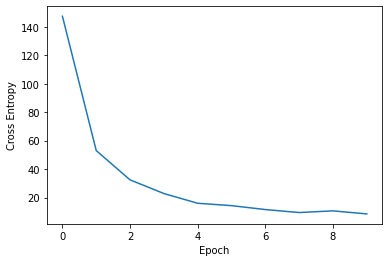

In [29]:
epoch = [i for i in range(epochSize)]
plt.plot(epoch, losses)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.show()

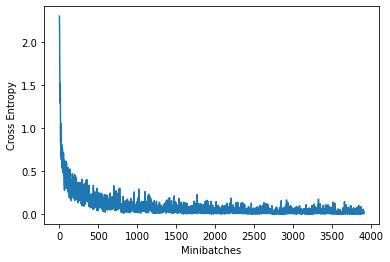

In [30]:
itr = [i for i in range(len(batch_losses))]
plt.plot(itr, batch_losses.detach().numpy())
plt.xlabel("Minibatches")
plt.ylabel("Cross Entropy")
plt.show()

##Check 4 Training and test accuracy

In [32]:
model.load_state_dict(torch.load('model8.weights'))
test_loss, test_batch_loss, test_acc, test_wrong = evaluate(test_loader, model, epochSize, loss_fn, device)

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
print("Simple MLP 3 layer")
print("Number of parameters:", count_parameters(model))
print("\nTraining:") 
print("number of data =", len(train_data))
print("number of wrongly predicted label =", wrong_pred)
print("accuracy = ", accuracy)

print("\n\nCross Validation: ")
print("number of data =", len(valid_data))
print("number of wrongly predicted label =", valid_wrong)
print("accuracy = ", valid_acc)

print("\n\nTest: ")
print("number of data =", len(test))
print("number of wrongly predicted label =", test_wrong)
print("accuracy = ", test_acc)

Simple MLP 3 layer
Number of parameters: 3367466

Training:
number of data = 50000
number of wrongly predicted label = 329
accuracy =  99.34263107416879


Cross Validation: 
number of data = 10000
number of wrongly predicted label = 368
accuracy =  96.36075949367088


Test: 
number of data = 10000
number of wrongly predicted label = 894
accuracy =  91.08979430379746


###Q1. What are the combinations of parameters-hyperparameters that allows you to achieve the highest accuracy without overfitting?

Model |#Hidden layers|#Hidden neurons|Epoch|#weights|optimizer|learningrate|minbatchsize|trainig size|validation size|test size|train accuracy|test accuracy|validation accuracy
------|--------------|---------------|-----|--------|---------|------------|------------|------------|---------------|---------|--------------|------------|--------|
1     |     1        | 1024          |10   | 814090 |Adam | 0.001 | 128 | 50000 |10000| 10000 | 99.938	| 91.1689 | 96.578
2     |       2       |[512, 512] |	10|	669706|	Adam|	0.001 |128|	50000	|10000|	10000|	99.482|	90.674|	95.985
3|	2	|[1568, 512]	|10	|2039338	|Adam	|0.001	|128	|50000	|10000|	10000|	99.37|	91.6|	96.26
4| 3	|[1024, 512, 256]	|10	|1462538	|Adam	|0.001	|128	|50000	|10000	|10000	|99.449|	90.704	|96.09375
5|2	|[2048, 1024]	|10	|3716106|	Adam|	0.001|	128	|50000|	10000|	10000|	99.45|	91.3469|	96.45965
6|3	|[1568, 1024, 512]	|10|	3367466|	Adam|	0.001|	128|	50000|	10000|	10000|	99.1548|	90.73|	96.33
7|2	|[2048, 1568]	|15	|4836202	|Adam|	0.001|	128	|50000|	10000|	10000|	99.47|	91.9699|	96.95
8|4	|[1568, 1024, 521, 256]	|15|	3507763|	Adam|	0.001|	128|	50000|	10000|	10000|	99.52|	91.278|	95.945
9|2	|[2048, 1568]	|15	|4836202|	SGD|	0.01|	128	|50000|	10000|	10000|	89.648|	77.5|	88.91
10|3	|[1568, 512, 512]	|100	|2301994|	SGD|	0.01|	128|	50000|	10000|	10000|	99.998|	89.26|	95.7

#Task 2. Compute Shannon Entropy

##Q1. Create probability distribution of the train data P(x)

In [35]:
def compute_probability_dist(dataset):
  data_np = dataset.data.numpy()
  flattened = np.zeros((len(dataset), 28*28))
  for i in range (len(dataset)):
    flattened[i] = data_np[i].flatten()

  d = {}
  for i in range(flattened.shape[1]): #784
    d[i+1] = {}
    for k in range(0, 256):
      d[i+1][k] = 0
    for j in range(flattened.shape[0]): 
      if flattened.T[i][j] in d[i+1].keys():
        d[i+1][flattened.T[i][j]] +=1

  prob_dict = {}
  for i in range(1, 785):
    prob_dict[i] = {}
    for j in range(0,256):
      prob_dict[i][j] = d[i][j] / len(dataset)
      
  return prob_dict


In [36]:
prob_train = compute_probability_dist(dataset) #is a nested dictionary with size {784: {256}}

In [59]:
len(prob_train[784])

256

In [37]:
print(len(prob_train), len(prob_train[1]))
print("{123: {") 
for i in range(10):
  print("   ",i,":", prob_train[123][i],"}")
print("...}")

784 256
{123: {
    0 : 0.5062666666666666 }
    1 : 0.014683333333333333 }
    2 : 0.008733333333333333 }
    3 : 0.007066666666666666 }
    4 : 0.0062 }
    5 : 0.004916666666666666 }
    6 : 0.004166666666666667 }
    7 : 0.0037833333333333334 }
    8 : 0.003766666666666667 }
    9 : 0.00335 }
...}


##Q2. Create probability distribution of the test data Q(x)

In [38]:
probability_test = compute_probability_dist(test)

##Q3. Visualize P(x) and Q(x) for pixel position/feature #123

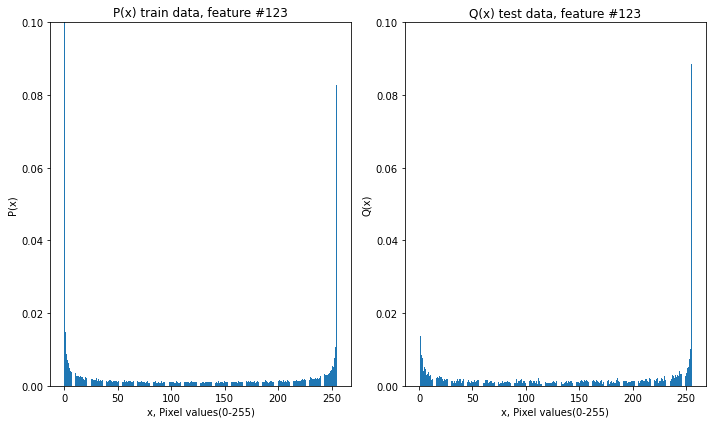

In [39]:
sample_train = list(prob_train[123].values())
sample_test = list(probability_test[123].values())
x = [i for i in range(256)]

plt.subplots(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(x, sample_train)
plt.title("P(x) train data, feature #123")
plt.xlabel("x, Pixel values(0-255)")
plt.ylabel("P(x)")
plt.ylim(0, 0.1)

plt.subplot(1, 2, 2)
plt.bar(x, sample_test)
plt.ylim(0, 0.1)
plt.title("Q(x) test data, feature #123")
plt.xlabel("x, Pixel values(0-255)")
plt.ylabel("Q(x)")

plt.tight_layout()
plt.show()

##Q4 Compute the Shannon Entropy

In [60]:
def compute_entropy(p):
  shannon_ent = np.zeros(784)
  for i in range(1, len(p)):
    total = 0
    for j in range(len(p[i])):
      if (p[i][j] != 0):
        total += (-p[i][j] * np.log2(p[i][j]))
    shannon_ent[i-1] = total
  return shannon_ent

In [63]:
train_entropy = compute_entropy(prob_train)
test_entropy = compute_entropy(probability_test)

In [64]:
print("Entropy for train data H(x): {}".format(train_entropy.sum()))
print("Entropy for test data H(x): {}".format(test_entropy.sum()))

Entropy for train data H(x): 2447.0124690309603
Entropy for test data H(x): 2407.038998771369


###a) Plot the -P(X)log2[P(x)] (training) and -Q(X)log2[Q(x)] (testing).

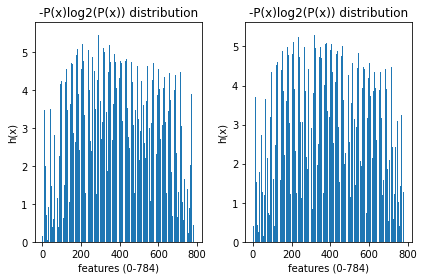

In [66]:
x = [i for i in range(784)]
plt.subplot(1, 2, 1)
plt.bar(x, train_entropy)
plt.title("-P(x)log2(P(x)) distribution")
plt.xlabel("features (0-784)")
plt.ylabel("h(x)")

plt.subplot(1, 2, 2)
plt.bar(x, test_entropy)
plt.title("-P(x)log2(P(x)) distribution")
plt.xlabel("features (0-784)")
plt.ylabel("h(x)")

plt.tight_layout()
plt.show()